En este proyecto se analizará el triunfo (o no) de una gran serie de películas. Se buscarán las claves que hacen que una buena pelicula lo sea y, como fin último, desarrollar un modelo de predicción para conocer de antemano si la próxima película que vas a ver merecerá la pena.

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Cargamos el dataset

In [2]:
df = pd.read_csv("filmaffinity_dataset.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119003 entries, 0 to 119002
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Título      119003 non-null  object
 1   Año         119003 non-null  int64 
 2   País        119003 non-null  object
 3   Dirección   118202 non-null  object
 4   Reparto     94525 non-null   object
 5   Nota        119003 non-null  object
 6   Tipo filme  119003 non-null  object
 7   Género      119003 non-null  object
dtypes: int64(1), object(7)
memory usage: 8.2+ MB


In [4]:
df.head()

,Título,Año,País,Dirección,Reparto,Nota,Tipo filme,Género
0,'49-'17,1917,Estados Unidos,Ruth Ann Baldwin,"Joseph W. Girard, Leo Pierson, William Dyer, M...",--,Película,Western
1,"10,000 Years B.C. (C)",1916,Estados Unidos,Willis H. O'Brien,NaN,"5,1",Cortometraje,Comedia
2,1812,1912,Rusia,"Vasili Goncharov, Kai Hansen, Aleksandr Uralsky","Pavel Knorr, Vasili Goncharov, Aleksandra Gonc...",--,Película,Drama
3,20.000 leguas de viaje submarino (C),1907,Francia,Georges Méliès,Georges Méliès,"6,0",Cortometraje,Fantástico
4,A Bad Case (C),1909,Francia,Émile Cohl,NaN,"5,3",Cortometraje,Comedia


De primeras vemos que la variable objetivo (Nota) es de un tipo erroneo. Vamos a cambiarlo

In [5]:
df.Nota.replace({'--': np.nan}, inplace=True)

In [6]:
df.Nota.isna().sum()

50709

Tenemos un problema ya que casi la mitad del dataset no contiene el valor objetivo. Podriamos imputar un valor medio pero, como no estamos hablando de valores similares ya que dependen de otras features, no podemos. Por lo tanto, eliminamos esas entradas.

In [7]:
df.drop(df[df['Nota'].isna()].index, inplace=True)

Hay más valores perdidos?

In [8]:
df.isna().sum()

Título            0
Año               0
País              0
Dirección       384
Reparto       14164
Nota              0
Tipo filme        0
Género            0
dtype: int64

Tal y como hicimos con los valores inexistentes en nota. Para dirección y reparto, no hay nada que podamos hacer.

In [9]:
df.drop(df[df['Dirección'].isna()].index, inplace=True)
df.drop(df[df['Reparto'].isna()].index, inplace=True)

In [10]:
df.isna().sum()

Título        0
Año           0
País          0
Dirección     0
Reparto       0
Nota          0
Tipo filme    0
Género        0
dtype: int64

In [11]:
df.head()

,Título,Año,País,Dirección,Reparto,Nota,Tipo filme,Género
3,20.000 leguas de viaje submarino (C),1907,Francia,Georges Méliès,Georges Méliès,"6,0",Cortometraje,Fantástico
6,A Beast at Bay (C),1912,Estados Unidos,D.W. Griffith,"Mary Pickford, Edwin August, Alfred Paget, Mae...","5,4",Cortometraje,Drama
8,A Calamitous Elopement (C),1908,Estados Unidos,D.W. Griffith,"Harry Solter, Linda Arvidson, Charles Inslee, ...","4,6",Cortometraje,Comedia
10,A Christmas Carol (C),1910,Estados Unidos,"J. Searle Dawley, Charles Kent, Ashley Miller","William Bechtel, Viola Dana, Carey Lee, Shirle...","5,8",Cortometraje,Drama
23,A Fool There Was,1915,Estados Unidos,Frank Powell,"Theda Bara, Edward José, Mabel Frenyear, Runa ...","5,8",Película,"Drama, Romance"


La variable nota sigue siendo tipo object y el separador decimal es coma en vez de punto, por lo tanto, no podemos cambiar el tipo directamente sin arreglar esto antes.

In [12]:
df.Nota = df.Nota.str.replace(',', '.')

In [13]:
df.Nota = pd.to_numeric(df.Nota)

Ahora ya tenemos nuestro target con el tipo adecuado para aplicar un algoritmo de regresión.
Vamos a hacer un analisis rápido de lo que tenemos hasta ahora:

In [14]:
df.Nota.describe()

count    53922.000000
mean         5.445412
std          1.295901
min          1.200000
25%          4.600000
50%          5.600000
75%          6.400000
max          9.200000
Name: Nota, dtype: float64

In [15]:
pd.set_option('display.max_rows', None)

In [16]:
df.groupby('Género').Nota.count()

Género
Acción                                                                    1455
Acción, Animación                                                            3
Acción, Animación, Aventuras                                                 5
Acción, Animación, Aventuras, Ciencia ficción                                1
Acción, Animación, Aventuras, Ciencia ficción, Fantástico                    2
Acción, Animación, Aventuras, Fantástico                                     1
Acción, Animación, Aventuras, Fantástico, Infantil, Comedia                  1
Acción, Animación, Aventuras, Infantil, Comedia                              1
Acción, Animación, Ciencia ficción                                           2
Acción, Animación, Drama, Comedia                                            1
Acción, Animación, Fantástico                                                4
Acción, Animación, Fantástico, Romance                                       1
Acción, Aventuras                            

Vemos que los generos no son una clasificación simple. Existen mezclas de géneros, por lo tanto, debemos obtener los que son "género base" y crear un one hot encoding en donde se deje constancia de esta mezcla con una serie de features tipo [0, 0, 1, 1, 0] Donde las columnas correspondientes sean por ejemplo Accion, Comedia, Terror, Drama, Fantastico.
Pero antes vamos a inspeccionar un poco el dataset:

In [17]:
df_GeneroBase = df[~df['Género'].str.contains(',')]

<Axes: title={'center': 'Nota'}, xlabel='Género'>

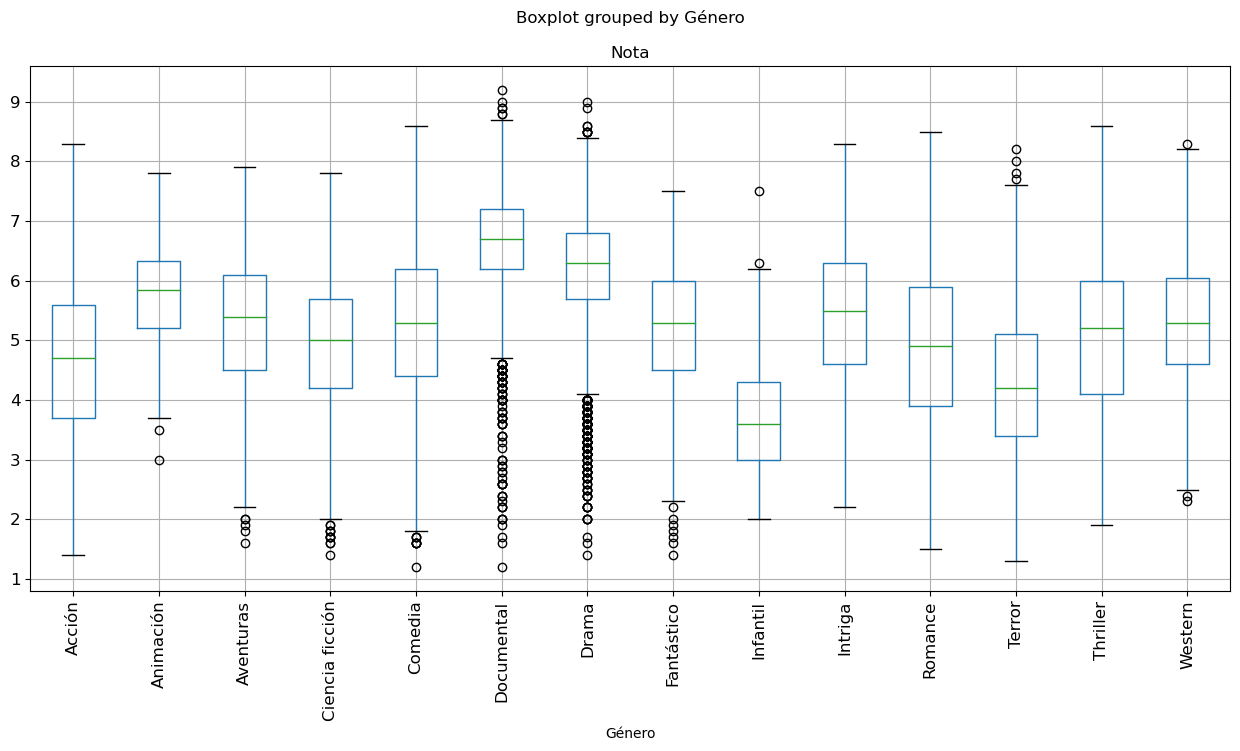

In [18]:
df_GeneroBase.boxplot(column='Nota', fontsize=12, figsize=(15, 7), grid=True, by='Género', rot=90)  

Sin contar las películas que tienen géneros "fusión", podemos ver a simple vista qué géneros están mejor valorados.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Acción'),
  Text(1, 0, 'Animación'),
  Text(2, 0, 'Aventuras'),
  Text(3, 0, 'Ciencia ficción'),
  Text(4, 0, 'Comedia'),
  Text(5, 0, 'Documental'),
  Text(6, 0, 'Drama'),
  Text(7, 0, 'Fantástico'),
  Text(8, 0, 'Infantil'),
  Text(9, 0, 'Intriga'),
  Text(10, 0, 'Romance'),
  Text(11, 0, 'Terror'),
  Text(12, 0, 'Thriller'),
  Text(13, 0, 'Western')])

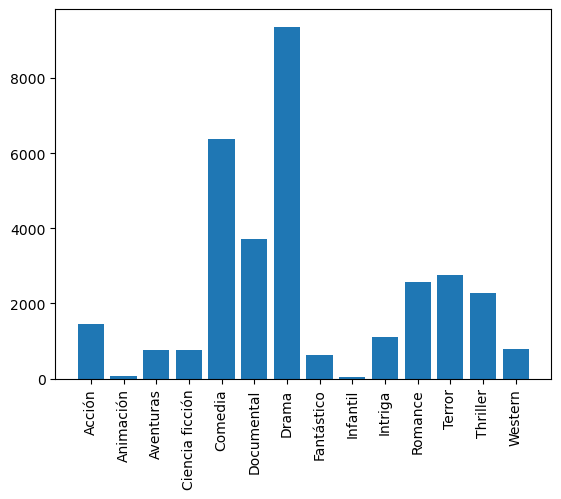

In [19]:
conteo_por_genero = df_GeneroBase.groupby('Género')['Género'].count()
plt.bar(conteo_por_genero.index, conteo_por_genero.values)
plt.xticks(rotation=90)

Y, en el espacio de tiempo que abarca este dataset, los géneros mayor producidos han sido Drama y Comedia.

In [20]:
df_GeneroBase.groupby('Género').Nota.describe()

,count,mean,std,min,25%,50%,75%,max
Género,,,,,,,,
Acción,1455.0,4.622268,1.203445,1.4,3.7,4.70,5.600,8.3
Animación,76.0,5.751316,0.926426,3.0,5.2,5.85,6.325,7.8
Aventuras,765.0,5.273725,1.142711,1.6,4.5,5.40,6.100,7.9
Ciencia ficción,772.0,4.825907,1.211361,1.4,4.2,5.00,5.700,7.8
Comedia,6378.0,5.250188,1.210649,1.2,4.4,5.30,6.200,8.6
Documental,3714.0,6.611174,0.860415,1.2,6.2,6.70,7.200,9.2
Drama,9362.0,6.192373,0.940680,1.4,5.7,6.30,6.800,9.0
Fantástico,639.0,5.205947,1.105853,1.4,4.5,5.30,6.000,7.5
Infantil,53.0,3.732075,1.126563,2.0,3.0,3.60,4.300,7.5


# ONE HOT ENCODING - Género

In [21]:
df['Género'] = df['Género'].str.replace(' ', '') #Eliminamos los espacios para evitar que get_dummies considere ' Acción' diferente a 'Acción'

In [22]:
df_generos = df['Género'].str.get_dummies(',')

In [23]:
df_generos.columns

Index(['Acción', 'Animación', 'Aventuras', 'Cienciaficción', 'Comedia',
       'Documental', 'Drama', 'Fantástico', 'Infantil', 'Intriga', 'Romance',
       'Terror', 'Thriller', 'Western'],
      dtype='object')

In [24]:
df_generos.head()

,Acción,Animación,Aventuras,Cienciaficción,Comedia,Documental,Drama,Fantástico,Infantil,Intriga,Romance,Terror,Thriller,Western
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,0,0,0,0
23,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [25]:
df_generos[(df_generos['Acción'] == 1) & (df_generos['Aventuras'] == 1)].head()

,Acción,Animación,Aventuras,Cienciaficción,Comedia,Documental,Drama,Fantástico,Infantil,Intriga,Romance,Terror,Thriller,Western
2592,1,0,1,0,0,0,1,0,0,0,0,0,0,0
4555,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4556,1,0,1,0,0,0,0,0,0,0,0,0,0,0
5039,1,0,1,0,0,0,1,0,0,0,1,0,0,0
6081,1,0,1,0,0,0,0,0,0,0,0,0,0,0


In [26]:
pd.set_option('display.max_rows', 10)
df_OHE = pd.concat([df, df_generos], axis=1)
df_OHE

,Título,Año,País,Dirección,Reparto,Nota,Tipo filme,Género,Acción,Animación,...,Comedia,Documental,Drama,Fantástico,Infantil,Intriga,Romance,Terror,Thriller,Western
3,20.000 leguas de viaje submarino (C),1907,Francia,Georges Méliès,Georges Méliès,6.0,Cortometraje,Fantástico,0,0,...,0,0,0,1,0,0,0,0,0,0
6,A Beast at Bay (C),1912,Estados Unidos,D.W. Griffith,"Mary Pickford, Edwin August, Alfred Paget, Mae...",5.4,Cortometraje,Drama,0,0,...,0,0,1,0,0,0,0,0,0,0
8,A Calamitous Elopement (C),1908,Estados Unidos,D.W. Griffith,"Harry Solter, Linda Arvidson, Charles Inslee, ...",4.6,Cortometraje,Comedia,0,0,...,1,0,0,0,0,0,0,0,0,0
10,A Christmas Carol (C),1910,Estados Unidos,"J. Searle Dawley, Charles Kent, Ashley Miller","William Bechtel, Viola Dana, Carey Lee, Shirle...",5.8,Cortometraje,Drama,0,0,...,0,0,1,0,0,0,0,0,0,0
23,A Fool There Was,1915,Estados Unidos,Frank Powell,"Theda Bara, Edward José, Mabel Frenyear, Runa ...",5.8,Película,"Drama,Romance",0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118992,¿Qué te juegas?,2019,España,Inés de León,"Leticia Dolera, Amaia Salamanca, Javier Rey, M...",4.4,Película,Comedia,0,0,...,1,0,0,0,0,0,0,0,0,0
118993,À coeur battant,2019,Francia,Keren Ben Rafael,"Judith Chemla, Arieh Worthalter, Lenny Dahan, ...",6.0,Película,Romance,0,0,...,0,0,0,0,0,0,1,0,0,0
118996,Érase una segunda vez (Miniserie de TV),2019,Francia,Guillaume Nicloux,"Gaspard Ulliel, Freya Mavor, Patrick D'Assumça...",5.2,Miniserie,"Cienciaficción,Romance",0,0,...,0,0,0,0,0,0,1,0,0,0
118999,Érase una vez en... Hollywood,2019,Estados Unidos,Quentin Tarantino,"Leonardo DiCaprio, Brad Pitt, Margot Robbie, E...",7.1,Película,"Drama,Comedia,Thriller",0,0,...,1,0,1,0,0,0,0,0,1,0


Perfecto. Ahora debemos hacer OHE tambien con la feature 'Tipo filme'

In [27]:
df_tipo = df['Tipo filme'].str.get_dummies()
df_tipo

,Cortometraje,Documental,Estreno televisivo,Miniserie,Película,Serie
3,1,0,0,0,0,0
6,1,0,0,0,0,0
8,1,0,0,0,0,0
10,1,0,0,0,0,0
23,0,0,0,0,1,0
...,...,...,...,...,...,...
118992,0,0,0,0,1,0
118993,0,0,0,0,1,0
118996,0,0,0,1,0,0
118999,0,0,0,0,1,0


In [28]:
df_OHE = pd.concat([df_OHE, df_tipo], axis=1)
df_OHE

,Título,Año,País,Dirección,Reparto,Nota,Tipo filme,Género,Acción,Animación,...,Romance,Terror,Thriller,Western,Cortometraje,Documental,Estreno televisivo,Miniserie,Película,Serie
3,20.000 leguas de viaje submarino (C),1907,Francia,Georges Méliès,Georges Méliès,6.0,Cortometraje,Fantástico,0,0,...,0,0,0,0,1,0,0,0,0,0
6,A Beast at Bay (C),1912,Estados Unidos,D.W. Griffith,"Mary Pickford, Edwin August, Alfred Paget, Mae...",5.4,Cortometraje,Drama,0,0,...,0,0,0,0,1,0,0,0,0,0
8,A Calamitous Elopement (C),1908,Estados Unidos,D.W. Griffith,"Harry Solter, Linda Arvidson, Charles Inslee, ...",4.6,Cortometraje,Comedia,0,0,...,0,0,0,0,1,0,0,0,0,0
10,A Christmas Carol (C),1910,Estados Unidos,"J. Searle Dawley, Charles Kent, Ashley Miller","William Bechtel, Viola Dana, Carey Lee, Shirle...",5.8,Cortometraje,Drama,0,0,...,0,0,0,0,1,0,0,0,0,0
23,A Fool There Was,1915,Estados Unidos,Frank Powell,"Theda Bara, Edward José, Mabel Frenyear, Runa ...",5.8,Película,"Drama,Romance",0,0,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118992,¿Qué te juegas?,2019,España,Inés de León,"Leticia Dolera, Amaia Salamanca, Javier Rey, M...",4.4,Película,Comedia,0,0,...,0,0,0,0,0,0,0,0,1,0
118993,À coeur battant,2019,Francia,Keren Ben Rafael,"Judith Chemla, Arieh Worthalter, Lenny Dahan, ...",6.0,Película,Romance,0,0,...,1,0,0,0,0,0,0,0,1,0
118996,Érase una segunda vez (Miniserie de TV),2019,Francia,Guillaume Nicloux,"Gaspard Ulliel, Freya Mavor, Patrick D'Assumça...",5.2,Miniserie,"Cienciaficción,Romance",0,0,...,1,0,0,0,0,0,0,1,0,0
118999,Érase una vez en... Hollywood,2019,Estados Unidos,Quentin Tarantino,"Leonardo DiCaprio, Brad Pitt, Margot Robbie, E...",7.1,Película,"Drama,Comedia,Thriller",0,0,...,0,0,1,0,0,0,0,0,1,0


Ahora vamos a ver qué podemos hacer para transformar tanto el reparto como la dirección en features usables para un problema de regresión.

# EDA 2

Vamos a revisar la evolución en cuanto a valoración de usuario por año incluyendo las películas que fusionan el genero analizado con otros.
Para esto, crearemos una función para generar un gráfico del género deseado:

In [53]:
def plot_nota_media_multiple_lines(columns, df):
    plt.figure(figsize=(15,7))
    for col in columns:
        media_nota_por_año = df[df[col] == 1].groupby('Año').Nota.mean()
        plt.plot(media_nota_por_año.index, media_nota_por_año.values, label=col)
        plt.xticks(rotation=90)
    plt.legend()
    

In [29]:
def plot_evolucion_nota(genero):
    media_nota_por_año = df_OHE[df_OHE[genero] == 1].groupby('Año').Nota.mean()
    plt.plot(media_nota_por_año.index, media_nota_por_año.values)
    plt.xticks(rotation=90)

In [30]:
df_OHE.columns.values[-5] = 'TipoDocumental'
df_OHE.columns

Index(['Título', 'Año', 'País', 'Dirección', 'Reparto', 'Nota', 'Tipo filme',
       'Género', 'Acción', 'Animación', 'Aventuras', 'Cienciaficción',
       'Comedia', 'Documental', 'Drama', 'Fantástico', 'Infantil', 'Intriga',
       'Romance', 'Terror', 'Thriller', 'Western', 'Cortometraje',
       'TipoDocumental', 'Estreno televisivo', 'Miniserie', 'Película',
       'Serie'],
      dtype='object')

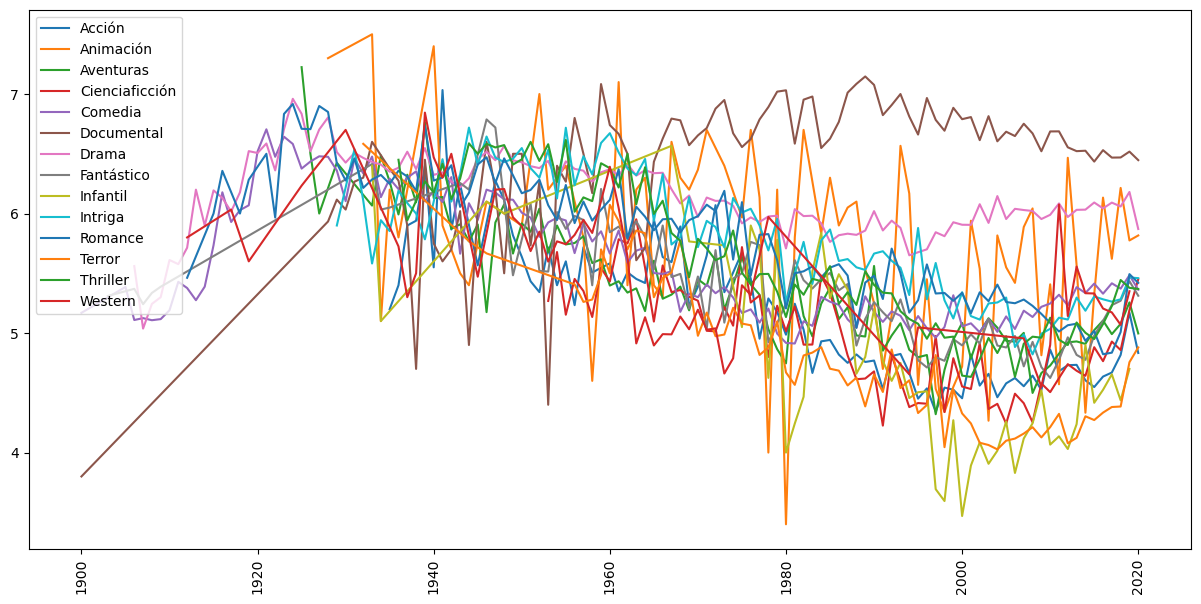

In [54]:
plot_nota_media_multiple_lines(['Acción', 'Animación', 'Aventuras', 'Cienciaficción',
       'Comedia', 'Documental', 'Drama', 'Fantástico', 'Infantil', 'Intriga',
       'Romance', 'Terror', 'Thriller', 'Western'], df_OHE)

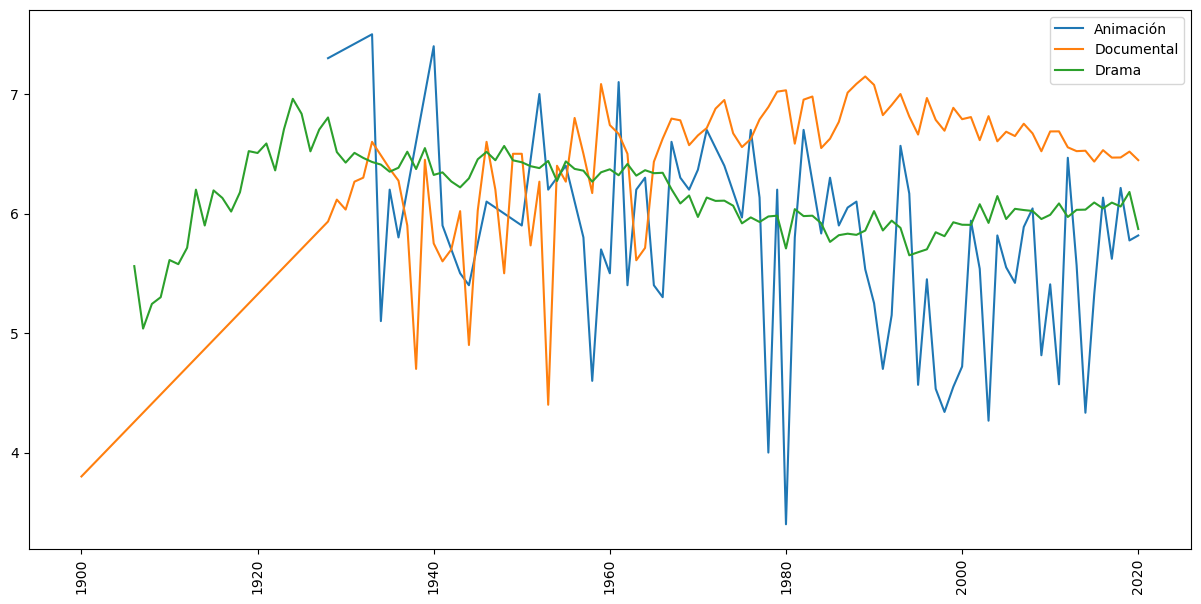

In [57]:
plot_nota_media_multiple_lines(['Animación', 'Documental', 'Drama'], df_OHE)

Se puede observar una tendencia descendente clara, de la nota media, en casi todos los generos. Los únicos generos que se desmarcan de esta tendencia son los documentales, los dramas y la animación.

En el caso de dramas parece tener sentido ahora por qué es significativamente el género con mayor producción.
En el caso de las animaciones, podemos ver un gráfico "ruidoso". Este puede deberse a la baja cantidad de muestras contenidas en el dataset.

Hipótesis 1: "El público tiende a comparar lo pasado con lo actual. Por lo tanto, los 'clásicos' del pasado rebajan la nota las películas que los siguen".

Test 1: Eliminar esta relación pasado-presente extrayendo la tendencia de la serie.

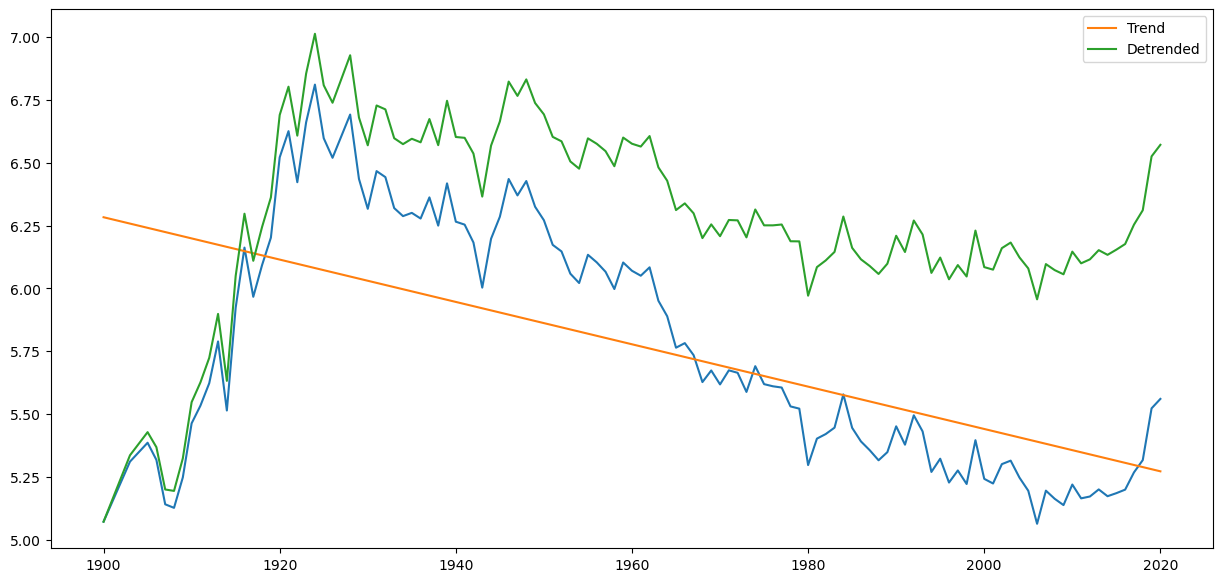

In [105]:
X = df_OHE.groupby('Año').Nota.mean().index
X = np.reshape(X, (len(X), 1))
y = df_OHE.groupby('Año').Nota.mean().values

model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)


plt.figure(figsize=(15,7))
plt.plot(X, y)
plt.plot(X, trend, label='Trend')
plt.plot(X, y-trend+(trend[0]), label='Detrended')

model2 = LinearRegression()
model2.fit(X, y - trend)

plt.legend()

Aunque no hemos podido eliminar esa tendencia alcista inicial correspondiente a la etapa de inicio del cine. Si que hemos conseguidos eliminar la tendencia en el punto de consolidación de la industria.

Vamos a inspeccionar esta eliminación de la tendencia a partir del año 1930 ya que podriamos suponer que es al rededor de este año en donde las peliculas empiezan a valorarse de una forma homogenea.

<Axes: title={'center': 'Nota'}, xlabel='Año'>

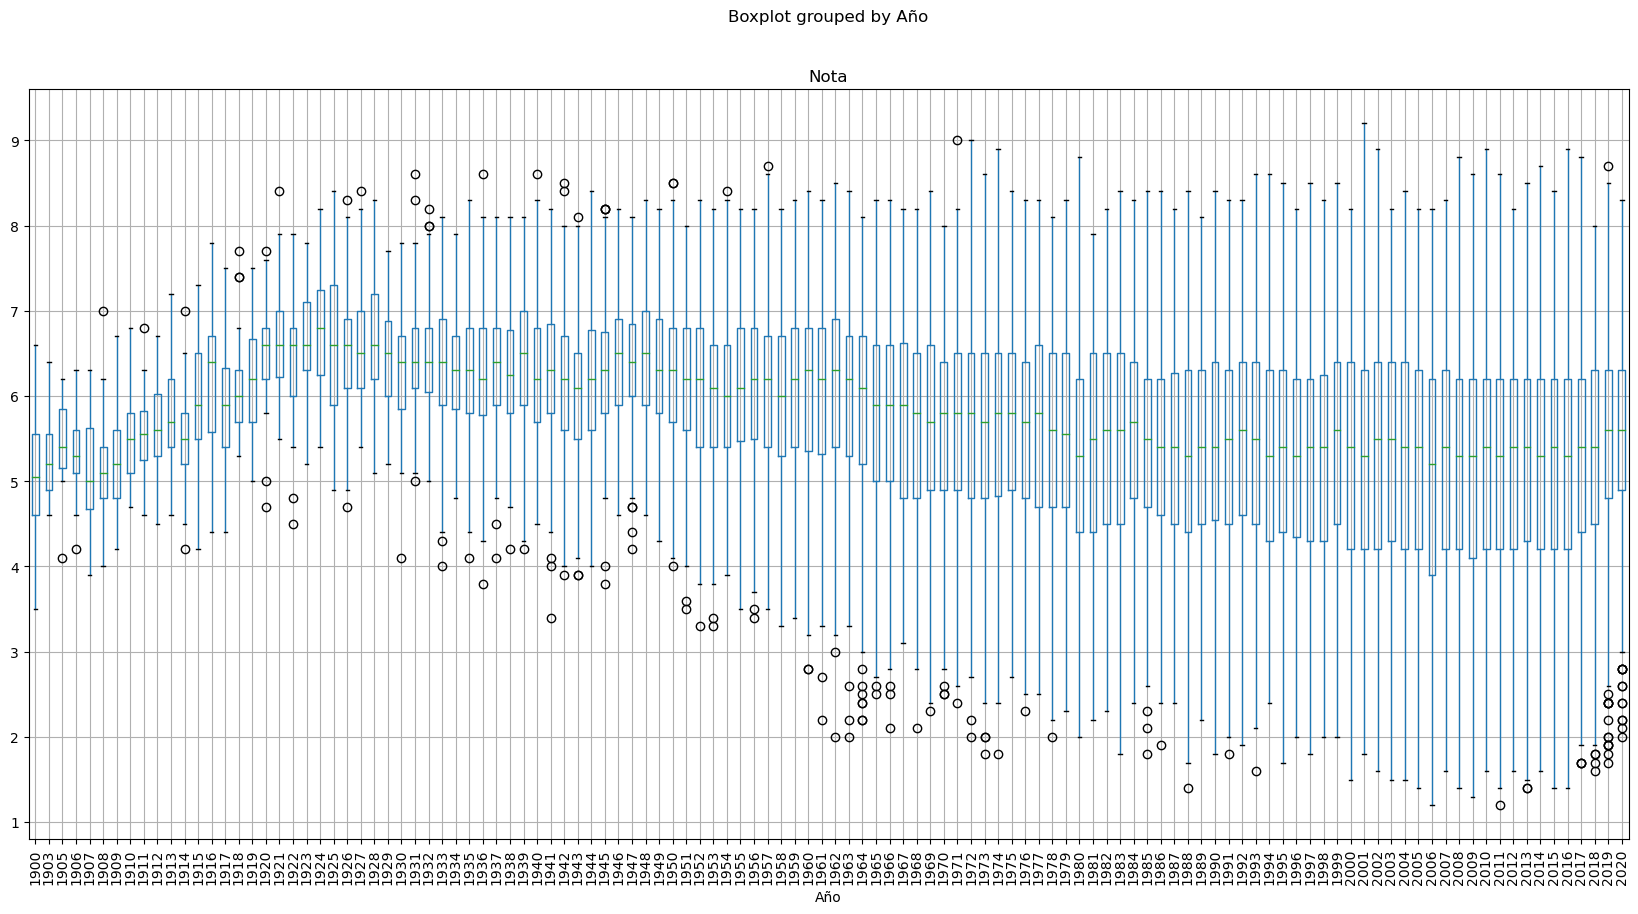

In [108]:
df_OHE.boxplot(column='Nota', fontsize=10, figsize=(20, 10), grid=True, by='Año', rot=90)  

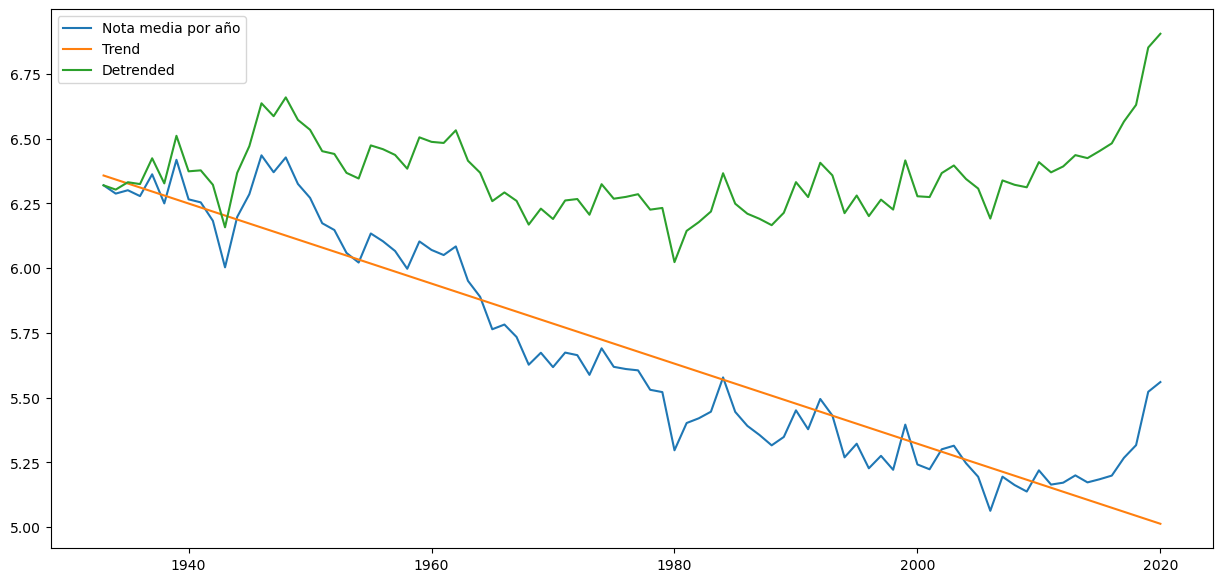

In [110]:
X = df_OHE.groupby('Año').Nota.mean().index[30:]
X = np.reshape(X, (len(X), 1))
y = df_OHE.groupby('Año').Nota.mean().values[30:]

model = LinearRegression()
model.fit(X, y)

trend = model.predict(X)


plt.figure(figsize=(15,7))
plt.plot(X, y, label='Nota media por año')
plt.plot(X, trend, label='Trend')
plt.plot(X, y-trend+(trend[0]), label='Detrended')

model2 = LinearRegression()
model2.fit(X, y - trend)

plt.legend()

En este caso ya podemos observar que si eliminamos la tendencia, dentro de un período temporal de negocio ya consolidado, podemos sacar conclusiones más certeras ya que eliminamos el sesgo de comparación.

Tambien se puede ver tanto en este último grafico, como en el anterior de cajas y bigotes, que en los últimos años de la serie se está viviendo un cambio de tendencia notable.

Vamos a eliminar la tendencia del dataset original para ver este efecto según los diferentes géneros del cine:

In [117]:
X = df_OHE['Año']
X = np.reshape(X, (len(X), 1))
nota_detrend = model.predict(X)
df_OHE['Nota_detrend'] = df_OHE['Nota'] - nota_detrend + trend[0]

<Axes: title={'center': 'Nota_detrend'}, xlabel='Género'>

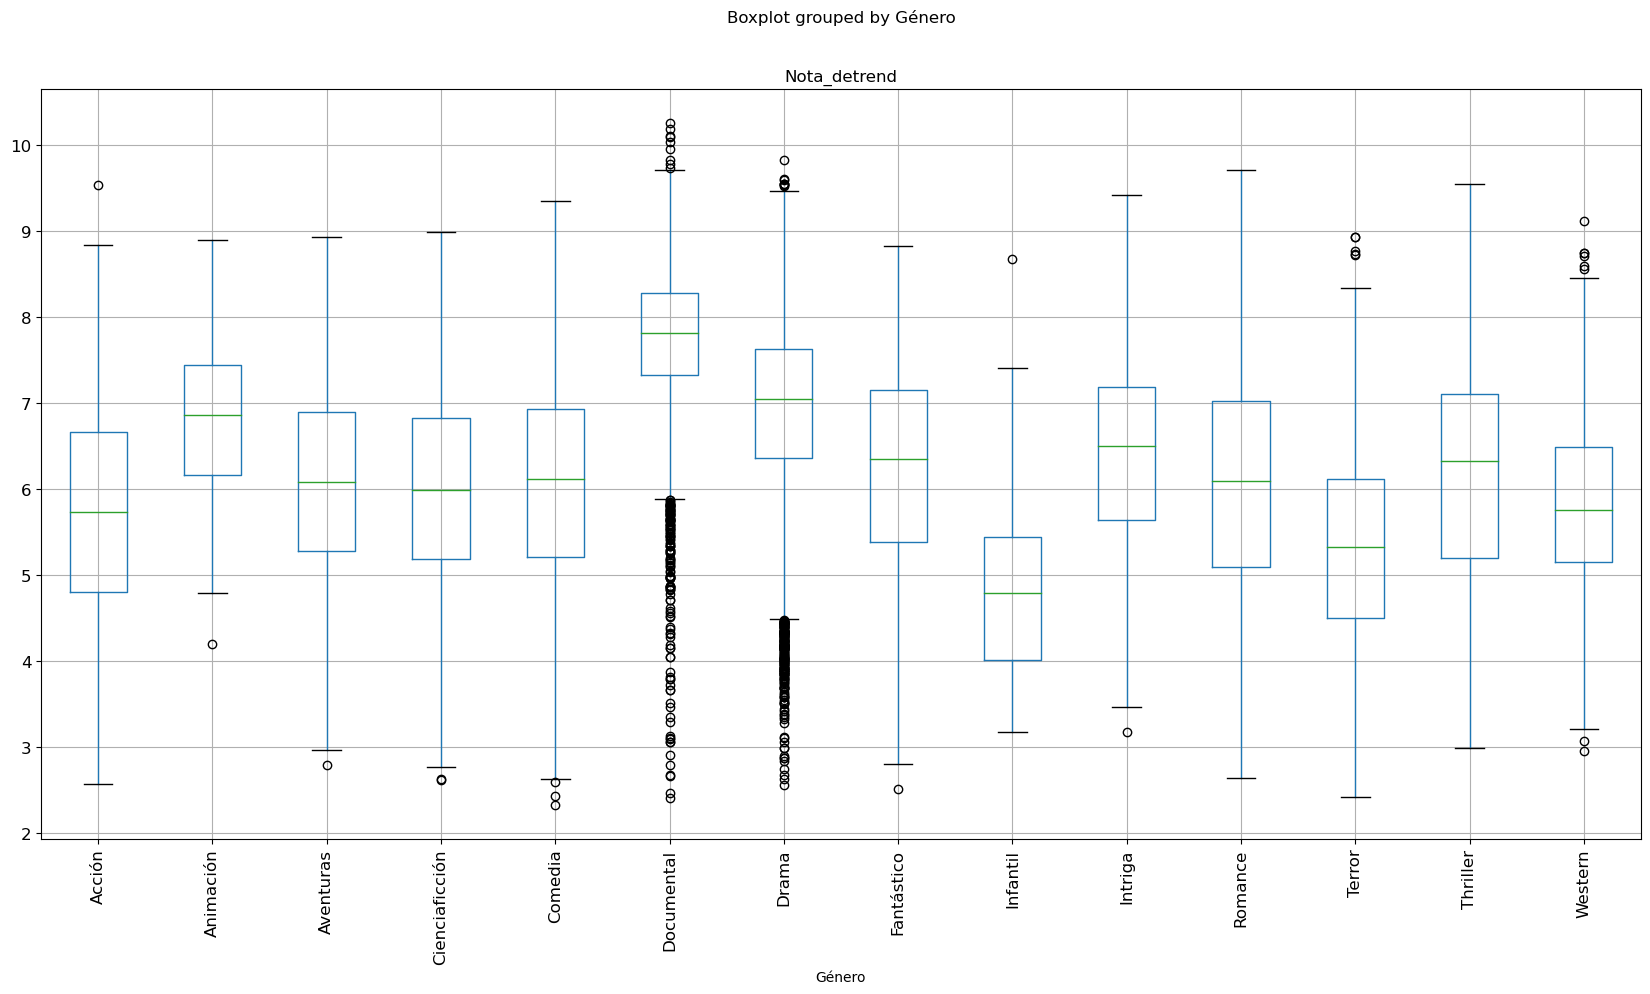

In [125]:
df_OHE[~df['Género'].str.contains(',')].boxplot(column='Nota_detrend', fontsize=12, figsize=(20, 10), grid=True, by='Género', rot=90)  

# ¿Puede verse afectada la producción de películas de un género por la recepción del público (nota media) de películas similares en el pasado?